In [1]:
import os
import yaml
import numpy as np
import pandas as pd

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import tensorboard as tb
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

plt.style.use('ggplot')

import sys
sys.path.append('./../')

from utilities.utils import EvalReport

In [2]:
def read_event_file(path):
    info = []
    for event in summary_iterator(path):
        step = event.step
        for summary_value in event.summary.value:
            tag = summary_value.tag
            val = summary_value.simple_value
            info.append([step, tag, val])
    df = pd.DataFrame(info, columns=['step', 'tag', 'value'])
    dfp = df.pivot_table(values='value', index='step', columns='tag')
    return dfp

In [3]:
def get_event_file_from_folder(runs_path, folder_name):
    folder_path = os.path.join(runs_path, folder_name)
    files = os.listdir(folder_path)
    if len(files)>1:
        print('More then 1 files.')
    return os.path.join(folder_path, files[0])

# Comparison VQ-VAE vs dVAE

In [ ]:
RUNS_PATH = './../runs_saved/'

In [7]:
event_folder = 'Aug07_15-30-21_smith_comparison_vqvae_cub128_v512_ds2_vocabsep.yaml'
path_vqvae_vs = get_event_file_from_folder(RUNS_PATH, event_folder)

event_folder = 'Aug07_15-36-37_rename_comparison_vqvae_cub128_v512_ds2_jointopt.yaml'
path_vqvae_jo = get_event_file_from_folder(RUNS_PATH, event_folder)

event_folder = 'Aug07_15-34-13_piet_comparison_dvae_cub128_v512_ds2.yaml'
path_dvae = get_event_file_from_folder(RUNS_PATH, event_folder)

event_folder = 'Aug09_15-49-33_zombie_comparison_dvae_cub128_v512_ds2_fixed_kl.yaml'
path_dvae_fkl = get_event_file_from_folder(RUNS_PATH, event_folder)

event_folder = 'Aug09_12-36-15_smith_dvae_cub64_v512_ds2.yaml'
path_dvae_64 = get_event_file_from_folder(RUNS_PATH, event_folder)

In [8]:
df_vqvae_vs = read_event_file(path_vqvae_vs)
df_vqvae_jo = read_event_file(path_vqvae_jo)
df_dvae = read_event_file(path_dvae)
df_dvae_fkl = read_event_file(path_dvae_fkl)
df_dvae_64 = read_event_file(path_dvae_64)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
NCodesUsed_vqvae_vs = df_vqvae_vs['additional_info/n_codes_used'].values
NCodesUsed_vqvae_jo = df_vqvae_jo['additional_info/n_codes_used'].values
NCodesUsed_dvae = df_dvae['additional_info/n_codes_used'].values
NCodesUsed_dvae_fkl = df_dvae_fkl['additional_info/n_codes_used'].values
NCodesUsed_dvae_64 = df_dvae_64['additional_info/n_codes_used'].values

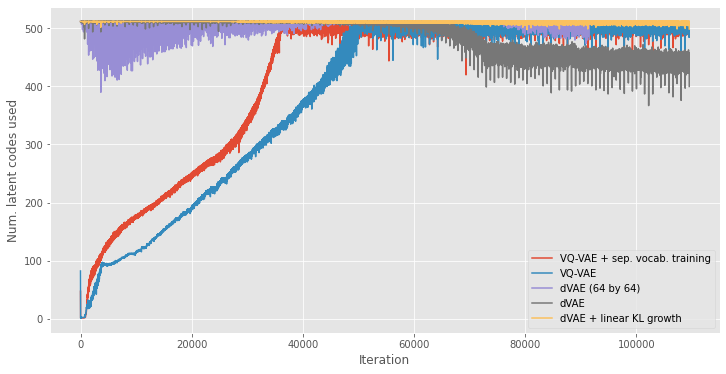

In [10]:
plt.figure(figsize=(12,6))

plt.plot(NCodesUsed_vqvae_vs, label='VQ-VAE + sep. vocab. training')
plt.plot(NCodesUsed_vqvae_jo, label='VQ-VAE')
plt.plot(NCodesUsed_dvae_64, label='dVAE (64 by 64)')
plt.plot(NCodesUsed_dvae_fkl, label='dVAE')
plt.plot(NCodesUsed_dvae, label='dVAE + linear KL growth')

plt.xlabel('Iteration')
plt.ylabel('Num. latent codes used')

plt.legend()
plt.show()

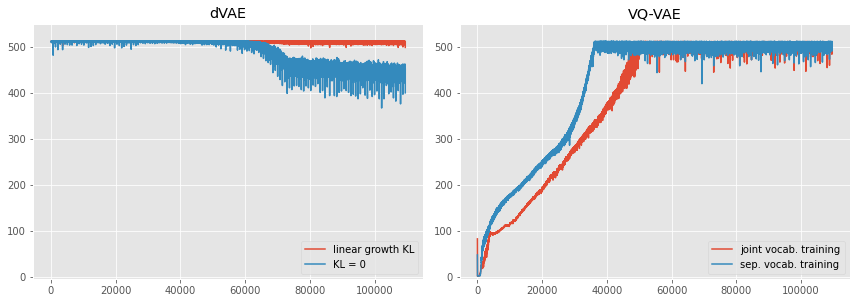

In [11]:
plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
plt.title('dVAE')
plt.plot(NCodesUsed_dvae, label='linear growth KL')
plt.plot(NCodesUsed_dvae_fkl, label='KL = 0')
plt.legend(loc='lower right')
plt.ylim([-5, 550])

plt.subplot(2, 2, 2)
plt.title('VQ-VAE')
plt.plot(NCodesUsed_vqvae_jo, label='joint vocab. training')
plt.plot(NCodesUsed_vqvae_vs, label='sep. vocab. training')
plt.legend(loc='lower right')
plt.ylim([-5, 550])

plt.tight_layout()
plt.show()

# CICS metric calculation

In [4]:
RUNS_PATH = './../runs_eval/'

In [5]:
event_folders_1 = [
    'Aug22_14-37-53_zombie_eval_by_img_dist_1.yaml/additional_info_cics_G1',
    'Aug22_14-40-07_false_eval_by_img_dist_2.yaml/additional_info_cics_G1',
    'Aug22_14-42-00_deadfish_eval_by_img_dist_3.yaml/additional_info_cics_G1',
    'Aug22_15-01-34_numberwang_eval_by_img_dist_4.yaml/additional_info_cics_G1',
    'Aug24_13-09-26_fugue_eval_by_img_dist_5.yaml/additional_info_cics_G1',
    'Aug24_13-11-18_smith_eval_by_img_dist_6.yaml/additional_info_cics_G1'
]

event_folders_2 = [
    'Aug22_14-37-53_zombie_eval_by_img_dist_1.yaml/additional_info_cics_G2',
    'Aug22_14-40-07_false_eval_by_img_dist_2.yaml/additional_info_cics_G2',
    'Aug22_14-42-00_deadfish_eval_by_img_dist_3.yaml/additional_info_cics_G2',
    'Aug22_15-01-34_numberwang_eval_by_img_dist_4.yaml/additional_info_cics_G2',
    'Aug24_13-09-26_fugue_eval_by_img_dist_5.yaml/additional_info_cics_G2',
    'Aug24_13-11-18_smith_eval_by_img_dist_6.yaml/additional_info_cics_G2'
]

dfs_g1 = []
dfs_g2 = []
for i in range(4):
    path_1 = get_event_file_from_folder(RUNS_PATH, event_folders_1[i])
    path_2 = get_event_file_from_folder(RUNS_PATH, event_folders_2[i])
    
    df1 = read_event_file(path_1)
    df2 = read_event_file(path_2)
    
    dfs_g1.append(df1)
    dfs_g2.append(df2)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
df_g1 = pd.concat(dfs_g1)
df_g2 = pd.concat(dfs_g2)

values_g1 = df_g1.iloc[:,0].values
values_g2 = df_g2.iloc[:,0].values

In [29]:
len(values_g1), len(values_g2), len(values_g1) + len(values_g2)

(273, 273, 546)

In [8]:
values_g1.sum(), values_g2.sum()

(13546.0, 13754.0)

In [9]:
values_g1.mean(), values_g2.mean()

(49.61904761904762, 50.38095238095238)

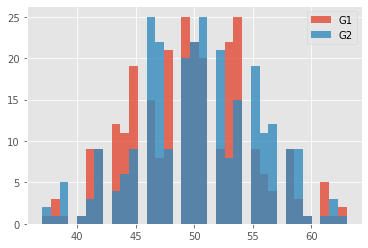

In [28]:
plt.hist(values_g1, bins=35, alpha=0.8, label='G1')
plt.hist(values_g2, bins=35, alpha=0.8, label='G2')
plt.legend()
plt.show()

In [11]:
ttest_ind(values_g1, values_g2, alternative='two-sided')

Ttest_indResult(statistic=-1.7224719573696037, pvalue=0.08555241290572486)

In [12]:
ttest_ind(values_g1, values_g2, alternative='less')

Ttest_indResult(statistic=-1.7224719573696037, pvalue=0.04277620645286243)

In [13]:
ttest_ind(values_g1, values_g2, alternative='greater')

Ttest_indResult(statistic=-1.7224719573696037, pvalue=0.9572237935471376)

In [14]:
ttest_ind(np.random.normal(loc=0, size=100), np.random.normal(loc=10, size=100), alternative='less')

Ttest_indResult(statistic=-69.35562042018323, pvalue=3.647961667582714e-141)

In [15]:
reps = []

for i in range(1, 5):
    rep = EvalReport(root_path='./../reports/', report_name='clip_mnist_md_report_tb_{}'.format(i))
    rep.load()
    reps.append(rep.report)

In [16]:
dists = list(map(lambda x: x['CLIP_evaluation']['CTRS'], reps))

In [17]:
dist_g1 = np.zeros(13)
dist_g2 = np.zeros(13)

for d in dists:
    dist_g1 += np.array([d['dist_G1'][i] for i in range(13)])
    dist_g2 += np.array([d['dist_G2'][i] for i in range(13)])

In [18]:
log_dist_g1 = np.log(dist_g1)
log_dist_g2 = np.log(dist_g2)

log_dist_g1[log_dist_g1==-np.inf] = np.nan
log_dist_g2[log_dist_g2==-np.inf] = np.nan

<ipython-input-18-bd3ba534d323>:1: RuntimeWarning: divide by zero encountered in log
  log_dist_g1 = np.log(dist_g1)
<ipython-input-18-bd3ba534d323>:2: RuntimeWarning: divide by zero encountered in log
  log_dist_g2 = np.log(dist_g2)


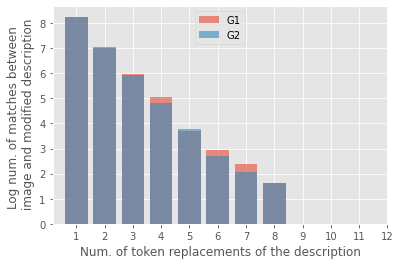

In [19]:
plt.bar(range(1, 13), log_dist_g1[1:], alpha=0.6, label='G1')
plt.bar(range(1, 13), log_dist_g2[1:], alpha=0.6, label='G2')

plt.xticks(range(1,13), range(1,13))

plt.xlabel('Num. of token replacements in the description')
plt.ylabel('Log num. of matches between \n image and modified description')

plt.legend()
plt.show()

In [20]:
_dt = pd.DataFrame([dist_g1, dist_g2], index=['G1', 'G2']).astype(int)
_dt

,0,1,2,3,4,5,6,7,8,9,10,11,12
G1,21692,3858,1128,388,158,41,19,11,5,0,0,0,0
G2,21750,3833,1146,374,125,43,15,8,5,1,0,0,0


In [21]:
_dt.iloc[0, 1:].sum(), _dt.iloc[1, 1:].sum()

(5608, 5550)

In [22]:
' & '.join(map(str, _dt.columns))

'0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12'

In [23]:
' & '.join(map(str, _dt.iloc[0, :].values))

'21692 & 3858 & 1128 & 388 & 158 & 41 & 19 & 11 & 5 & 0 & 0 & 0 & 0'

In [24]:
' & '.join(map(str, _dt.iloc[1, :].values))

'21750 & 3833 & 1146 & 374 & 125 & 43 & 15 & 8 & 5 & 1 & 0 & 0 & 0'

# CUB 64 and 128 train

In [101]:
RUNS_PATH = './../runs_saved/'

cub128_1_name = 'Jul22_14-50-47_smith_trArC2s2s_cub_v512_ds2_nb12_cnb16_remote.yaml'
cub128_2_name = 'Jul28_16-30-43_smith_trArC2s2s_cub_v512_ds2_nb12_cnb16_remote_continue.yaml'
cub64_name = 'Aug20_13-47-05_smith_Tr2s2s_cub64_v512_ds2_nb14_cnb8.yaml'

path128_1 = get_event_file_from_folder(RUNS_PATH, cub128_1_name)
path128_2 = get_event_file_from_folder(RUNS_PATH, cub128_2_name)
path64 = get_event_file_from_folder(RUNS_PATH, cub64_name)

df128_1 = read_event_file(path128_1)
df128_2 = read_event_file(path128_2)
df64 = read_event_file(path64)

In [112]:
loss_128 = np.concatenate([
    df128_1.iloc[:,0].values,
    df128_2.iloc[:,0].values
])

loss_64 = df64.iloc[:,0].values

In [123]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

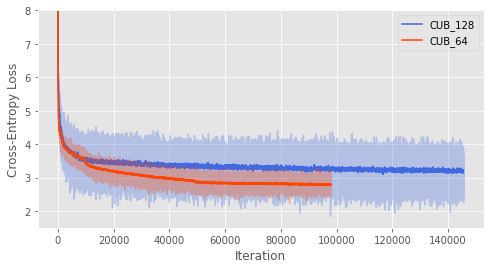

In [146]:
plt.figure(figsize=(8, 4))

plt.plot(loss_128, alpha=0.3, c='royalblue')
plt.plot(moving_average(loss_128, 100), label='CUB_128', c='royalblue')
plt.plot(loss_64, alpha=0.3, c='orangered')
plt.plot(moving_average(loss_64, 100), label='CUB_64', c='orangered')

plt.ylim(1.5, 8)

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')

plt.show()